In [1]:
%matplotlib inline
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

print("TF version: ", tf.__version__)
print("Keras version: ", keras.__version__)

TF version:  2.5.0
Keras version:  2.5.0


In [2]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_dev, y_dev) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
rescale = keras.Sequential([layers.experimental.preprocessing.Rescaling(1.0/255)])

In [4]:
X_train = tf.reshape(rescale(X_train), shape=(-1, 28, 28, 1))
X_dev = tf.reshape(rescale(X_dev), shape=(-1, 28, 28, 1))

In [5]:
X_train.shape, X_dev.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [6]:
transformations = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.01),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    layers.experimental.preprocessing.RandomZoom((-0.1, 0.1))
])
X_train_transformed = transformations(X_train)
X_dev_transformed = transformations(X_dev)

In [7]:
def plot_img(img: np.array, label: int):
    print('Number:', label)
    plt.imshow(img.squeeze(), cmap='Greys_r')

Number: 1


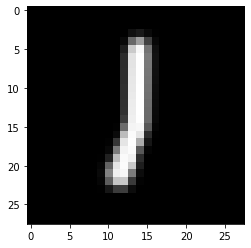

In [8]:
n = np.random.randint(X_train_transformed.shape[0])
plot_img(X_train_transformed[n].numpy(), y_train[n])

In [9]:
model = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Dropout(rate=0.3),

    layers.Flatten(),

    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)              

In [10]:
hist = model.fit(X_train_transformed, y_train,
    batch_size=32, epochs=15,
    validation_data=(X_dev_transformed, y_dev)
)

Epoch 1/15
1875/1875 [==============================] - 37s 3ms/step - loss: 0.3254 - accuracy: 0.8966 - val_loss: 0.0833 - val_accuracy: 0.9750
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1234 - accuracy: 0.9616 - val_loss: 0.0653 - val_accuracy: 0.9799
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0924 - accuracy: 0.9713 - val_loss: 0.0507 - val_accuracy: 0.9838
Epoch 4/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0787 - accuracy: 0.9752 - val_loss: 0.0605 - val_accuracy: 0.9810
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0660 - accuracy: 0.9790 - val_loss: 0.0419 - val_accuracy: 0.9871
Epoch 6/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0583 - accuracy: 0.9817 - val_loss: 0.0396 - val_accuracy: 0.9869
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0545 - accuracy: 0.9825 - val_loss: 0.0417 - val_accuracy

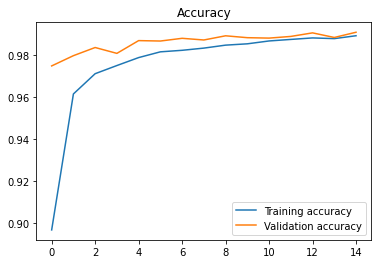

In [11]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['accuracy'])
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

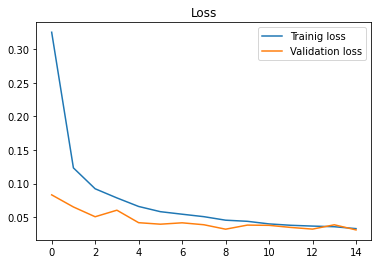

In [12]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

In [13]:
p_dev = np.argmax(model.predict(X_dev), axis=1)
p_train = np.argmax(model.predict(X_train), axis=1)

In [14]:
print("DEV F1 SCORE: ", f1_score(y_dev, p_dev, average='weighted'))
print("TRAIN F1 SCORE: ", f1_score(y_train, p_train, average='weighted'))

DEV F1 SCORE:  0.9922032223934062
TRAIN F1 SCORE:  0.9936841089508954


DEV CONFUSION MATRIX:


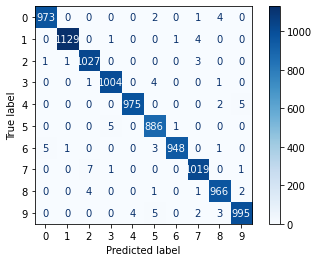

In [18]:
print("DEV CONFUSION MATRIX:")
cm = confusion_matrix(y_dev, p_dev)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(0, 10))
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation='horizontal', values_format='');

**TODO:**   
1. anomaly detection / outlier removal
2. Retrain the net with better data
3. test the network with external data
4. if succesful save the net and load in the web app, else repeat the steps again

In [19]:
p_train_logits = model.predict(X_train)

In [20]:
def clean_dataset(X, y, y_pred_logits, clean_percent: float = 0.1):
    N_TO_REMOVE = round(X.shape[0] * clean_percent)
    max_accuracies_array = np.array(y_pred_logits.max(axis=1))
    X_ = X.tolist()
    y_ = y.tolist()
    all_concat = list(zip(X_, y_, max_accuracies_array.tolist()))
    all_concat.sort(key=lambda x: x[2])
    X_new, y_new, _ = zip(*all_concat[N_TO_REMOVE:])
    return np.array(X_new), np.array(y_new)

In [21]:
X_train_clean, y_train_clean = clean_dataset(X_train.numpy(), y_train, p_train_logits, 0.05)
X_train_clean.shape, y_train_clean.shape

((57000, 28, 28, 1), (57000,))

In [22]:
X_train_clean_transformed = transformations(X_train_clean)

Number: 9


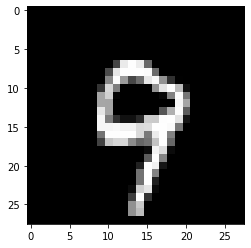

In [23]:
plot_img(X_train_clean[n], y_train_clean[n])

In [24]:
model2 = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Dropout(rate=0.3),

    layers.Flatten(),

    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)              

In [25]:
hist2 = model2.fit(X_train_clean_transformed, y_train_clean, 
                   batch_size=32, epochs=15, validation_data=(X_dev_transformed, y_dev))

Epoch 1/15
1782/1782 [==============================] - 7s 4ms/step - loss: 0.2841 - accuracy: 0.9084 - val_loss: 0.0900 - val_accuracy: 0.9722
Epoch 2/15
1782/1782 [==============================] - 7s 4ms/step - loss: 0.0833 - accuracy: 0.9745 - val_loss: 0.0654 - val_accuracy: 0.9796
Epoch 3/15
1782/1782 [==============================] - 6s 4ms/step - loss: 0.0598 - accuracy: 0.9809 - val_loss: 0.0613 - val_accuracy: 0.9806
Epoch 4/15
1782/1782 [==============================] - 6s 3ms/step - loss: 0.0484 - accuracy: 0.9847 - val_loss: 0.0601 - val_accuracy: 0.9817
Epoch 5/15
1782/1782 [==============================] - 6s 4ms/step - loss: 0.0417 - accuracy: 0.9866 - val_loss: 0.0535 - val_accuracy: 0.9842
Epoch 6/15
1782/1782 [==============================] - 6s 4ms/step - loss: 0.0335 - accuracy: 0.9893 - val_loss: 0.0508 - val_accuracy: 0.9846
Epoch 7/15
1782/1782 [==============================] - 6s 4ms/step - loss: 0.0309 - accuracy: 0.9898 - val_loss: 0.0520 - val_accuracy:

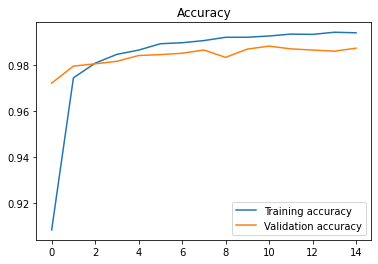

In [26]:
plt.title('Accuracy')
plt.plot(hist2.epoch, hist2.history['accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

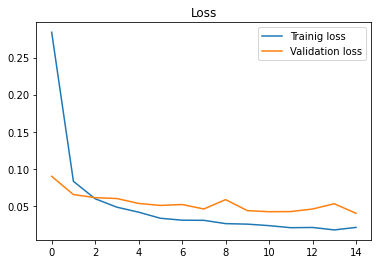

In [27]:
plt.title('Loss')
plt.plot(hist2.epoch, hist2.history['loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

## Comparando os modelos

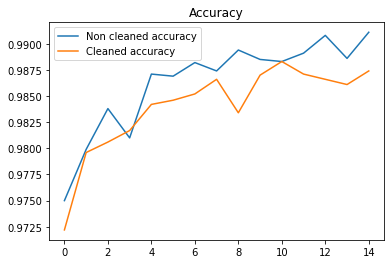

In [28]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['Non cleaned accuracy', 'Cleaned accuracy'])
plt.show();

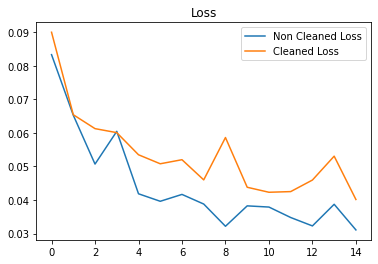

In [29]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['val_loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['Non Cleaned Loss', 'Cleaned Loss'])
plt.show();

In [30]:
print("Non cleaned F1 Score:", f1_score(y_dev, np.argmax(model.predict(X_dev), axis=1), average='weighted'))
print("Cleaned F1 Score:", f1_score(y_dev, np.argmax(model2.predict(X_dev), axis=1), average='weighted'))

Non cleaned F1 Score: 0.9922032223934062
Cleaned F1 Score: 0.9897053579117248


### Analysing  the results

Apparently, the model trained with the cleaned data seems to be working worse than the first one, but if we pay attention to the fact that the dev data was not cleaned although it was used for validating the model trained with the cleaned data, so in real data, the results may be different.

In [31]:
one = tf.constant([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16326458752155304, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0.5714263319969177, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285658299922943, 1, 1, 0.4897943437099457, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.24489717185497284, 1, 1, 1, 0, 1, 1, 0.14286039769649506, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.9996798634529114, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20408114790916443, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4285736083984375, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.9983993172645569, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.5918376445770264, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.28571316599845886, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9990395307540894, 0.7543814182281494, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], shape=(1, 28, 28, 1))

Number: 1


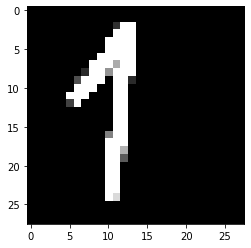

In [32]:
plot_img(one.numpy(), 1)

In [33]:
p = model.predict(one)
print(p.max())
np.argmax(p)

0.9998355


1

In [34]:
p = model2.predict(one)
print(p.max())
np.argmax(p)

0.9998982


1

In [35]:
model2.save('./DigitModel.h5')